## Importing Dataset from Kaggle

In [ ]:
! mkdir -p ~/.kaggle

In [ ]:
! cp  ./drive/MyDrive/Colab_Notebooks/cnn_project/kaggle/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification -p ./drive/MyDrive/Colab_Notebooks/cnn_project/datasets/

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
 92% 59.0M/64.4M [00:00<00:00, 97.4MB/s]
100% 64.4M/64.4M [00:00<00:00, 90.7MB/s]


In [ ]:
dir_path = './drive/MyDrive/Colab_Notebooks/cnn_project/datasets'

In [ ]:
# Unzip data in my google Drive
import zipfile

zip_ref = zipfile.ZipFile(dir_path + '/cats-and-dogs-image-classification.zip', 'r')
zip_ref.extractall(dir_path + '/cats-and-dogs')
zip_ref.close()


In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Preprocessing Data

In [2]:
# Libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
dir_path = './drive/MyDrive/Colab_Notebooks/cnn_project/datasets'

In [4]:
# Creating data generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = dir_path + '/cats-and-dogs/train',  # Directory to train data
    labels = 'inferred',                            # Keras indicates labels based on folders name
    label_mode = 'int',                             # indicats the labels are intiger
    batch_size = 2,                                 # Batch size is defined 2
    image_size = (150, 150),                        # change the image size in (150,150)
    shuffle = True                                  # randomly selection for better generalizing
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = dir_path + '/cats-and-dogs/validate',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 2,
    image_size = (150, 150),
    shuffle = True
)
class_names_train = train_ds.class_names
class_names_validation = validation_ds.class_names

print(class_names_train)
print(class_names_validation)


Found 1000 files belonging to 2 classes.
Found 260 files belonging to 2 classes.
['cat', 'dog']
['cat', 'dog']


In [5]:
from PIL import Image
import os

img_path = "./drive/MyDrive/Colab_Notebooks/cnn_project/datasets/cats-and-dogs/train/cat/0 (1).png"
img = Image.open(img_path)

print("Original size:", img.size)  # Output: (width, height)


Original size: (224, 224)


In [6]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),    # Flipping data horizentaly
    tf.keras.layers.RandomRotation(0.05),        # Rotate data 5%
    tf.keras.layers.RandomZoom(0.05),            # Zoom data 5%
])


# Apply Augmentation Randomly to 50% of Images

def augmentation(image, label):
    return tf.cond(
        tf.random.uniform(()) > 0.5,             # just apply on 50%
        lambda: (data_augmentation(image, training=True), label),
        lambda: (image, label)
    )

# Apply augmentation only to train dataset
train_ds = train_ds.map(augmentation)


In [7]:
# Normalize
def process(image, label):
    image = tf.cast(image/255.0, tf.float32)
    # label = tf.cast(label, tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)


In [8]:
# Allows TensorFlow to automatically choose the best buffer size to improve performanc
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
# Show the data type
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch dtype: {image_batch.dtype}")
    print(f"Label batch dtype: {label_batch.dtype}")


Image batch dtype: <dtype: 'float32'>
Label batch dtype: <dtype: 'int32'>


In [10]:
# show the data size
for image_batch, label_batch in train_ds.take(1):
    print("Sample image batch shape:", image_batch.shape)
    print("Sample label batch shape:", label_batch.shape)

Sample image batch shape: (2, 150, 150, 3)
Sample label batch shape: (2,)


# **Creat and Train the Model**

In [ ]:
## CNN Model
# model = keras.Sequential()

# model.add(keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(150,150,3))) # Stride = 1
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

# model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

# model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

# model.add(keras.layers.Flatten())  # Transfer all matrix or tensors into a vector (1 D)

# model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(1, activation='sigmoid'))


In [22]:
# Resnet50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = True  # freezing layers yes/no
# Add custom classification head
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,141,569 (114.98 MB)

 Trainable params: 30,088,449 (114.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)



In [14]:
## Compiler for CNN Model
# model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])


In [24]:
# Compiler for Resnet50 Model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=[early_stop])


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 64ms/step - accuracy: 0.8375 - loss: 0.3826 - val_accuracy: 0.4769 - val_loss: 5.6415
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9921 - loss: 0.0360 - val_accuracy: 0.9692 - val_loss: 0.2179
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9938 - loss: 0.0243 - val_accuracy: 0.9885 - val_loss: 0.0749
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 0.9885 - val_loss: 0.0556
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9966 - loss: 0.0057 - val_accuracy: 0.9923 - val_loss: 0.0576
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 1.0000 - loss: 8.5549e-0

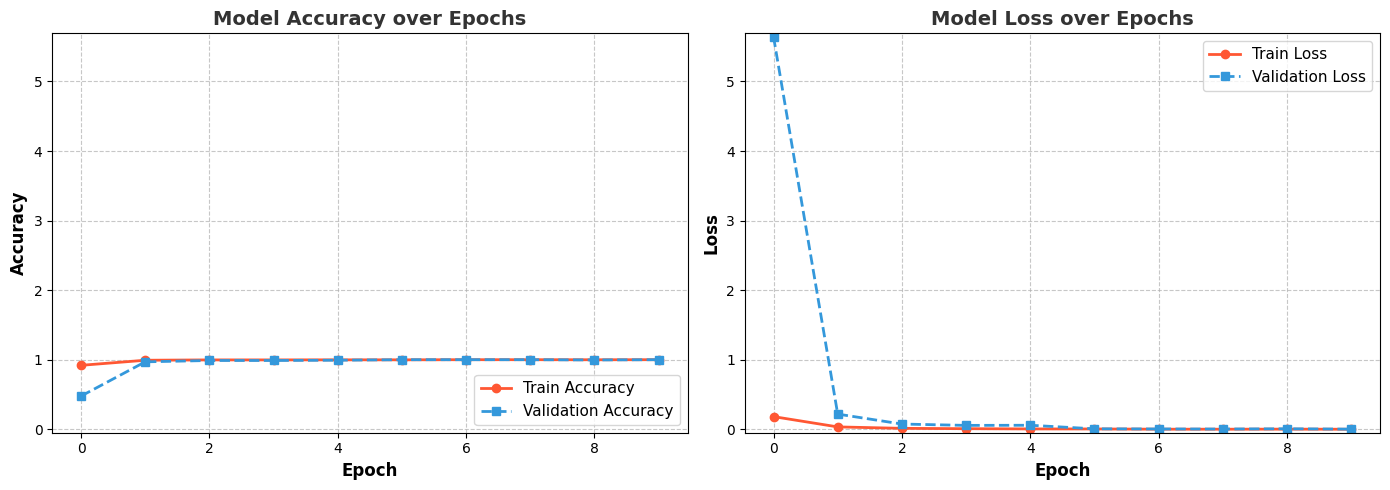

In [26]:
## Plot in bigger Scale
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Extract min/max values for consistent scaling
# acc_min = min(min(history.history['accuracy']), min(history.history['val_accuracy']))
# acc_max = max(max(history.history['accuracy']), max(history.history['val_accuracy']))
# loss_min = min(min(history.history['loss']), min(history.history['val_loss']))
# loss_max = max(max(history.history['loss']), max(history.history['val_loss']))

# # Set y-limits with some padding
# y_acc_min, y_acc_max = acc_min - 0.05, acc_max + 0.05  # Add padding for better visibility
# y_loss_min, y_loss_max = loss_min - 0.05, loss_max + 0.05

# # Ensure both graphs have the same scale range
# common_min = min(y_acc_min, y_loss_min)
# common_max = max(y_acc_max, y_loss_max)

# # Plot Accuracy
# axes[0].plot(history.history['accuracy'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Accuracy')
# axes[0].plot(history.history['val_accuracy'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Accuracy')
# axes[0].set_title("Model Accuracy over Epochs", fontsize=14, fontweight="bold", color="#333")
# axes[0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
# axes[0].set_ylabel("Accuracy", fontsize=12, fontweight="bold")
# axes[0].legend(fontsize=11, loc="lower right")
# axes[0].grid(True, linestyle="--", alpha=0.7)
# axes[0].set_ylim(common_min, common_max)  # Set same scale

# # Plot Loss
# axes[1].plot(history.history['loss'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss')
# axes[1].plot(history.history['val_loss'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Loss')
# axes[1].set_title("Model Loss over Epochs", fontsize=14, fontweight="bold", color="#333")
# axes[1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
# axes[1].set_ylabel("Loss", fontsize=12, fontweight="bold")
# axes[1].legend(fontsize=11, loc="upper right")
# axes[1].grid(True, linestyle="--", alpha=0.7)
# axes[1].set_ylim(common_min, common_max)  # Set same scale

# plt.tight_layout()
# plt.show()


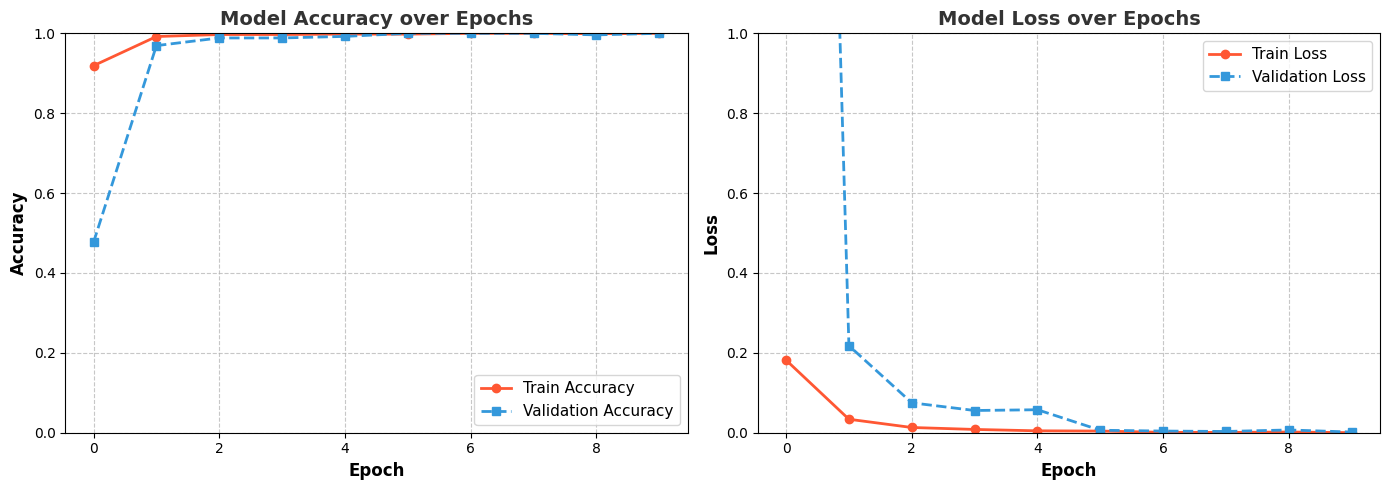

In [38]:
# Plot in smaller Scalle
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].plot(history.history['accuracy'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Accuracy')
axes[0].set_title("Model Accuracy over Epochs", fontsize=14, fontweight="bold", color="#333")
axes[0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Accuracy", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=11, loc="lower right")
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].set_ylim(0, 1.0)

# Loss Plot
axes[1].plot(history.history['loss'], color='#FF5733', marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss')
axes[1].plot(history.history['val_loss'], color='#3498DB', marker='s', linestyle='--', linewidth=2, markersize=6, label='Validation Loss')
axes[1].set_title("Model Loss over Epochs", fontsize=14, fontweight="bold", color="#333")
axes[1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Loss", fontsize=12, fontweight="bold")
axes[1].legend(fontsize=11, loc="upper right")
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


In [27]:
# Final Prediction
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"🔹 Final Training Accuracy:     {final_train_acc:.4f}")
print(f"🔹 Final Validation Accuracy:   {final_val_acc:.4f}")
print(f"🔸 Final Training Loss:         {final_train_loss:.4f}")
print(f"🔸 Final Validation Loss:       {final_val_loss:.4f}")


🔹 Final Training Accuracy:     1.0000
🔹 Final Validation Accuracy:   1.0000
🔸 Final Training Loss:         0.0002
🔸 Final Validation Loss:       0.0017


In [28]:
# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images)
    preds = preds.flatten()
    preds = np.where(preds > 0.5, 1, 0)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()

print(f"\n✅ True Positives (TP): {tp}")
print(f"❌ False Positives (FP): {fp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Negatives (FN): {fn}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

## Test the Model

In [ ]:
#model = keras.models.load_model('./drive/MyDrive/Colab_Notebooks/cnn_project/cnn_model.h5')  # Replace with your filename


# Test with unseen images

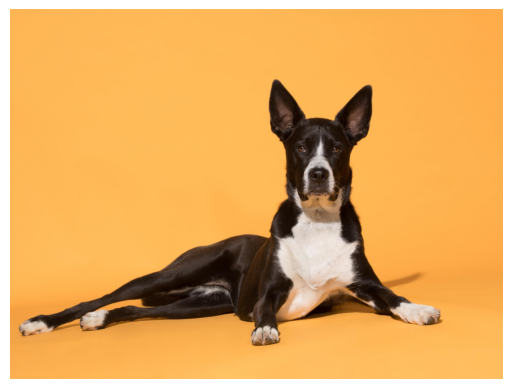

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: cat (Confidence: 0.0000)


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
test_image = cv2.imread(dir_path + "/Testdata/dog_32.jpg")

# Convert BGR to RGB (since OpenCV loads images in BGR format)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(test_image)
plt.axis("off")  # Hide axes
plt.show()

# Resize the image to match model input size
test_image = cv2.resize(test_image, (150, 150))

# Normalize the image (same as training data)
test_image = test_image / 255.0  # Normalize to range [0,1]

# Reshape for model input
test_output = np.expand_dims(test_image, axis=0)  # Same as (1, 150, 150, 3)

# Make prediction
final_predict = model.predict(test_output)[0][0]  # Extract scalar value

# Apply threshold
threshold = 0.5
predicted_class = "dog" if final_predict >= threshold else "cat"


# Print prediction
print(f"Predicted class: {predicted_class} (Confidence: {final_predict:.4f})")


In [ ]:
# Save to Google Drive
model.save("./drive/MyDrive/Colab_Notebooks/cnn_project/cnn_model.h5")
